In [1]:
using LinearAlgebra
using PlotlyJS
using FFTW
using BenchmarkTools
using Kronecker
using WAV

WebIO._IJuliaInit()

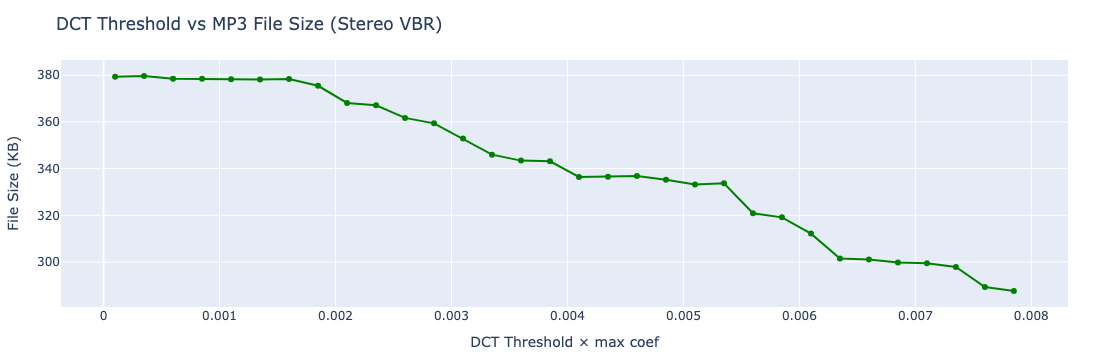

In [2]:
function dct_mp3_compression_analysis(input_mp3::String; thresholds=0.0001:0.00025:0.008)
    # Step 0: Prepare output directory
    outdir = "converted"
    mkpath(outdir)

    # Step 1: Convert MP3 to WAV
    run(pipeline(`ffmpeg -y -i $input_mp3 temp.wav -loglevel quiet`))

    # Step 2: Load WAV (stereo)
    signal, fs = wavread("temp.wav")

    sizes = Float64[]
    used_thresholds = Float64[]

    for t in thresholds
        # Step 3: Process each channel independently
        processed_channels = []
        for i in 1:size(signal, 2)  # loop over channels (columns)
            ch = signal[:, i]  # extract i-th channel
            dct_sig = dct(ch)
            thresh_val = t * maximum(abs.(dct_sig))
            compressed = dct_sig .* (abs.(dct_sig) .> thresh_val)
            recon = idct(compressed)
            norm_factor = recon ./ maximum(abs, recon)
            int_ch = convert.(Int16, round.(norm_factor .* typemax(Int16)))
            push!(processed_channels, int_ch)
        end

        # Step 4: Combine into stereo
        stereo = hcat(processed_channels...)

        # Step 5: File paths inside converted/
        wav_file = joinpath(outdir, "recon_$(round(Int, 1000000 * t)).wav")
        mp3_file = joinpath(outdir, "recon_$(round(Int, 1000000 * t))_vbr.mp3")

        # Step 6: Save and convert
        wavwrite(stereo, fs, wav_file)
        run(pipeline(`ffmpeg -y -i $wav_file -q:a 3 -loglevel quiet $mp3_file`))

        # Step 7: Measure size
        size_kb = stat(mp3_file).size / 1024
        push!(sizes, size_kb)
        push!(used_thresholds, t)
    end

    # Step 8: Plot
    plot(
        [scatter(x=used_thresholds, y=sizes, mode="lines+markers",
                name="MP3 file size (Stereo, VBR)", marker_color="green")],
        Layout(title="DCT Threshold vs MP3 File Size (Stereo VBR)",
               xaxis_title="DCT Threshold × max coef",
               yaxis_title="File Size (KB)")
    )
end

# Example usage
dct_mp3_compression_analysis("victory_wild.mp3")
